In [20]:
import os 
import sys 
import pandas as pd 
import numpy as np 
import math 
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(font='arial')
jakes_cmap = sns.diverging_palette(212, 61, s=99, l=77, sep=1, n=16, center='dark') #Custom aesthetics

__path__ = os.getcwd()
print(__path__)

E:\projects\ouyang_analysis\yeyun_rnaseq_2022_04_14\SWAP_wt_sd_1_1_WT_noPi_1_1


In [21]:
counts = pd.read_csv("yeyun_rnaseq_count_table_SWAPPED.txt", sep="\t", index_col=0)

In [22]:
metadata = pd.read_csv("yeyun_2022_04_novogene_metadata.txt", sep="\t")

In [23]:
data_order = [
    "WT", "pho85", "rpo41", "rpopho",
    "WT_Pi", "WT_noPi",
    "WT_SD", "WT_noURA",
    "Pro_wN", "Pro_noN",
    "ba", "ba_aF"
]

sample_order = []
for x in data_order:
    for y in metadata.loc[metadata["Condition"] == x]["Sample names"].tolist():
        sample_order.append(y)

In [24]:
counts = counts[sample_order]

In [25]:
counts.shape

(7127, 36)

## Normalize

In [26]:
rrna_list = [
    'RDN18-2', 
    'RDN5-1', 
    'RDN5-6', 
    'RDN5-2', 
    'ITS2-2', 
    'ITS2-1', 
    'ETS2-1', 
    'RDN5-5', 
    'RDN37-2', 
    'ITS1-1', 
    'Q0158', 
    'Q0020', 
    'ITS1-2', 
    'RDN58-2', 
    'ETS2-2', 
    'RDN18-1', 
    'RDN25-2', 
    'RDN25-1', 
    'RDN5-3', 
    'RDN58-1', 
    'RDN5-4', 
    'ETS1-2', 
    'RDN37-1', 
    'ETS1-1'
]

In [27]:
# rename genes
gene_dict_table = pd.read_csv(
    os.path.join(__path__, 'yeast_orf_dict.csv'), 
    sep=',',
    header=None) 
gene_dict_table[1] = gene_dict_table[1].fillna(gene_dict_table[0])

gene_dict = {}
info_dict = {}
for i, r in gene_dict_table.iterrows():
    gene_dict[r[0]] = r[1]
    info_dict[r[0]] = r[3]

In [28]:
rna_lengths_url = os.path.join(__path__, "sce_lengths.txt")
rna_lengths = pd.read_csv(
    rna_lengths_url,
    sep="\t",
    index_col=0)
rna_lengths.index.name = None
rna_length_dict = rna_lengths.to_dict()['Length']

In [29]:
rnaseq_tpm = counts.copy()
print("Initial dataframe size: " + str(rnaseq_tpm.shape))

# remove RNAs with less than 50 counts
rnaseq_tpm = rnaseq_tpm[rnaseq_tpm.min(axis=1) > 25]
print("Count thresholding: " + str(rnaseq_tpm.shape))

# remove RNAs with unmapped lengths -- most are dubious ORFs, ncRNAs, etc.
rnaseq_tpm['lengths'] = rnaseq_tpm.index.map(rna_length_dict)

rnaseq_tpm = rnaseq_tpm[~rnaseq_tpm['lengths'].isna()]
rnaseq_tpm['lengths'] = rnaseq_tpm['lengths'] / 1000
print("Remove misc. RNAs: " + str(rnaseq_tpm.shape))

# Step 1
rnaseq_tpm = rnaseq_tpm.divide((rnaseq_tpm['lengths']), axis=0) 
rnaseq_tpm.drop('lengths', axis=1, inplace=True)

# Step 2
rnaseq_tpm.loc['per_million'] = rnaseq_tpm.sum(axis=0) / 1e6

# Step 3
rnaseq_tpm = rnaseq_tpm.divide((rnaseq_tpm.loc['per_million']), axis=1) 
rnaseq_tpm.drop('per_million', axis=0, inplace=True)

# Check outputs 
print("\nCheck outputs:")
print(rnaseq_tpm.sum())

rnaseq_tpm.to_csv(
    os.path.join(__path__, 'counts_normalized.tsv'),
    sep="\t")

Initial dataframe size: (7127, 36)
Count thresholding: (5673, 36)
Remove misc. RNAs: (5391, 37)

Check outputs:
WT_1_1_Aligned          1000000.0
WT_2_1_Aligned          1000000.0
WT_3_1_Aligned          1000000.0
pho85_1_1_Aligned       1000000.0
pho85_2_1_Aligned       1000000.0
pho85_3_1_Aligned       1000000.0
rpo41_1_1_Aligned       1000000.0
rpo41_2_1_Aligned       1000000.0
rpo41_3_1_Aligned       1000000.0
rpopho_1_1_Aligned      1000000.0
rpopho_2_1_Aligned      1000000.0
rpopho_3_1_Aligned      1000000.0
WT_Pi_1_1_Aligned       1000000.0
WT_Pi_2_1_Aligned       1000000.0
WT_Pi_3_1_Aligned       1000000.0
WT_noPi_1_1_Aligned     1000000.0
WT_noPi_2_1_Aligned     1000000.0
WT_noPi_3_1_Aligned     1000000.0
WT_SD_1_1_Aligned       1000000.0
WT_SD_2_1_Aligned       1000000.0
WT_SD_3_1_Aligned       1000000.0
WT_noURA_1_1_Aligned    1000000.0
WT_noURA_2_1_Aligned    1000000.0
WT_noURA_3_1_Aligned    1000000.0
Pro_wN_1_1_Aligned      1000000.0
Pro_wN_2_1_Aligned      1000000.0
Pro_

In [30]:
rnaseq_tpm_named = rnaseq_tpm.copy()

rnaseq_tpm_named['common_name'] = rnaseq_tpm_named.index.to_series().replace(gene_dict)
rnaseq_tpm_named['description'] = rnaseq_tpm_named.index.to_series().replace(info_dict)

rnaseq_tpm_named.to_csv(
    os.path.join(__path__, 'counts_normalized_renamed.tsv'),
    sep="\t")

In [31]:
rnaseq_tpm_named.shape

(5391, 38)

## Heatmaps

In [32]:
rnaseq_tpm_plot = rnaseq_tpm_named.copy()
rnaseq_tpm_plot.index = rnaseq_tpm_plot['common_name']
rnaseq_tpm_plot.index.name = None
rnaseq_tpm_plot = rnaseq_tpm_plot.drop(["common_name", "description"], axis = 1)

In [33]:
colors = ["#a6cee3", "#1f78b4", "#b2df8a" ,"#33a02c" ,"#fb9a99" ,"#e31a1c" ,"#fdbf6f" ,"#ff7f00" ,"#cab2d6" ,"#6a3d9a" ,"#ffff99" ,"#b15928"] # From https://colorbrewer2.org/
counter = 0
simp_sample_hex = {}
for x in list(set(metadata["Condition"])):
    simp_sample_hex[x] = colors[counter]
    counter += 1

In [34]:
sample_colors = {}
for i, r in metadata.iterrows():
    sample_colors[r[0]] = [simp_sample_hex[r[1]]]

In [35]:
rnaseq_tpm_plot.shape

(5391, 36)

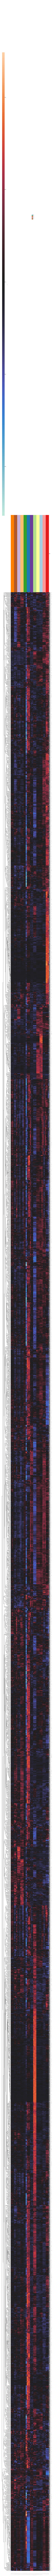

In [37]:
sns.set(font_scale=0.1)
sns.clustermap(
    rnaseq_tpm_plot,
    z_score=0,
    row_cluster=True,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    col_colors=pd.DataFrame.from_dict(sample_colors).T,
    figsize=(4,200))

# Label legends
g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [g("s", list(simp_sample_hex.values())[i]) for i in range(len(list(simp_sample_hex.values())))]
plt.legend(handles_g, list(simp_sample_hex.keys()), bbox_to_anchor=(11.75, 0.65), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(__path__, "rnaseq_allgenes_heatmap.pdf"),
    dpi=300,
    bbox_inches='tight')
plt.show()